In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import matplotlib.pyplot as plt
import swan_vis as swan
import yaml
from snakemake.io import expand
import cerberus
import pyranges as pr
import upsetplot

p = os.path.dirname(os.getcwd())
sys.path.append(p)

from scripts.utils import *
from scripts.vcf_utils import *
from scripts.plotting import *

In [2]:
config = load_config()
od = '../'

def proc_cfg(entry, od):
    entry = entry.replace('../../', '')
    entry = od+entry
    return entry

In [218]:
df = load_meta()
df = df.loc[~df['sample'].str.contains('_')]
df['lab_sample'] = df['lab_number_sample'].astype(str)+'_'+\
                      df['lab_sampleid'].astype(str)+'_'+\
                      df['cell_line_id'].astype(str)
df.columns
df = df[['cell_line_id', 'sample', 'hapmap_DNA_ID',
          'map_reads_assemblymap','lab_sample', 'population']].drop_duplicates()

temp_df = pd.read_csv('../snakemake/transcript_discovery_personal/cell_line_ids.txt', header=None, names=['cell_line_id'])

# make a 1000g cell line id col
df['cell_line_id_1000g'] = df.cell_line_id

inds = df.loc[~df.cell_line_id_1000g.isin(temp_df.cell_line_id.tolist())].index
df.loc[inds, 'cell_line_id_1000g'] = df.loc[inds, 'hapmap_DNA_ID']
len(df.index)

# limit to just those in 1000g
df = df.loc[df.cell_line_id_1000g.isin(temp_df.cell_line_id.tolist())]
assert len(df.index) == 30

# TODO bad sample that hasn't finished on espresso
# bad_samples = ['NA19328']
# df = df.loc[~df.cell_line_id_1000g.isin(bad_samples)]

hap = ['hap1', 'hap2']

meta_df = df.copy(deep=True)

## Try again

In [219]:
file = proc_cfg(config['lr']['td_personal']['cerb']['ic_summary'],od)
df = pd.read_csv(file)
df.drop('Unnamed: 0', axis=1, inplace=True)
df['detected'] = True

In [220]:
# 1.5 only novel ics and count per cell line
print(len(df.index))
temp = df.loc[(df.structural_category!='full-splice_match')&\
              (df.structural_category!='incomplete-splice_match')]
print(len(temp.index))

# get only the detection from mapping
temp = temp[['ic_id', 'cell_line_id', 'map_genome', 'detected']]
temp = temp.drop_duplicates()
print(len(temp.index))

temp = temp.pivot(index=['ic_id', 'cell_line_id'], 
                columns=['map_genome'],
                values=['detected'])

# flatten
temp.columns = temp.columns.get_level_values(1)
temp.columns.name = None

# reset index to make it a flat DataFrame
temp = temp.reset_index()

# fill missing values with False
temp = temp.fillna(False)

# det. in personal haps? 
temp['pers_hap'] = (temp.hap1==True)|(temp.hap2==True)
temp.drop(['hap1', 'hap2'], axis=1, inplace=True)

12993951
4280955
1426985


In [221]:
# count number of novel ICs det pers cell line
temp['n_novel_ic'] = temp.groupby('cell_line_id')['ic_id'].transform('nunique')
temp2 = temp[['cell_line_id', 'n_novel_ic']]
temp2 = temp2.sort_values(by='n_novel_ic', ascending=False).drop_duplicates()
order = temp2.cell_line_id.tolist()
samples_28 = order[:28]
samples_2 = order[-2:]

In [222]:
# first try to recreate the saturation / increases curves
ic_ids_hg38 = []
ic_ids_pers = []

cols = ['n_samples', 'genome', 'diff', 'n_cum_uniq']
df = pd.DataFrame()

for i, c in enumerate(order):
    
    # HG38
    
    things = [i, 'hg38']
    
    # get ics for hg38
    curr_ics = temp.loc[(temp.cell_line_id==c)&
                        (temp.hg38==True)].ic_id.unique().tolist()
    
    # difference between last and this one
    things.append(len(list(set(curr_ics)-set(ic_ids_hg38)))) # difference 
    
    # cumulative
    ic_ids_hg38 = list(set(curr_ics)|set(ic_ids_hg38)) # union
    things.append(len(ic_ids_hg38))
    
    temp3 = pd.DataFrame(data=[things], columns=cols)
    df = pd.concat([df, temp3], axis=0)
    
    # PERS
    
    things = [i, 'pers']
    
    # get ics for pers
    curr_ics = temp.loc[(temp.cell_line_id==c)&
                        (temp.pers_hap==True)].ic_id.unique().tolist()
    
    # difference between last and this one
    things.append(len(list(set(curr_ics)-set(ic_ids_pers)))) # difference 
    
    # cumulative
    ic_ids_pers = list(set(curr_ics)|set(ic_ids_pers)) # union
    things.append(len(ic_ids_pers))
    
    temp3 = pd.DataFrame(data=[things], columns=cols)
    df = pd.concat([df, temp3], axis=0)

In [223]:
df.loc[df.n_samples==29]

,n_samples,genome,diff,n_cum_uniq
0,29,hg38,658,99551
0,29,pers,694,103365


In [224]:
assert len(temp.loc[temp.pers_hap==True].ic_id.unique()) == df.loc[(df.n_samples==29)&(df.genome=='pers')]['n_cum_uniq'].values[0]
assert len(temp.loc[temp.hg38==True].ic_id.unique()) == df.loc[(df.n_samples==29)&(df.genome=='hg38')]['n_cum_uniq'].values[0]

In [225]:
df.tail()

,n_samples,genome,diff,n_cum_uniq
0,27,pers,639,101900
0,28,hg38,767,98893
0,28,pers,771,102671
0,29,hg38,658,99551
0,29,pers,694,103365


613


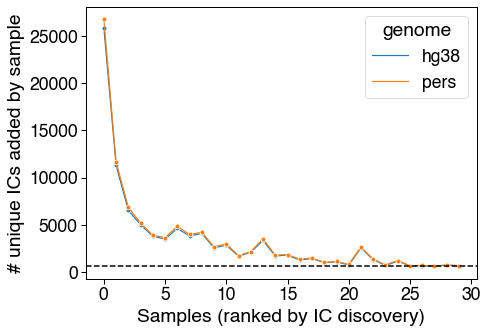

In [226]:
init_plot_settings(aspect='rectangle')
ax = sns.lineplot(data=df,
             x="n_samples",
             y="diff", hue='genome',
                marker="o")
ax.set(xlabel='Samples (ranked by IC discovery)', 
       ylabel='# unique ICs added by sample')
plt.axhline(y=df['diff'].min(), color="k",
            linestyle="--", linewidth=1.5, label=f"y = {df['diff'].min()}")
print(df['diff'].min())

[Text(0.5, 0, 'Samples (ranked by IC discovery)'),
 Text(0, 0.5, '# cumulative ICs added by sample')]

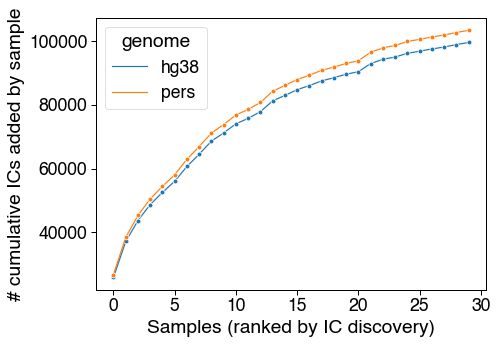

In [227]:
init_plot_settings(aspect='rectangle')
ax = sns.lineplot(data=df,
             x="n_samples",
             y="n_cum_uniq", hue='genome',
                marker="o")
ax.set(xlabel='Samples (ranked by IC discovery)', 
       ylabel='# cumulative ICs added by sample')

In [265]:
# columns = ['sample_28_index',
#            'n_ic_28_hg38', 
#            'n_ic_28_pers',
#            'n_ic_2_sample_rna_hg38',
#            'n_ic_2_sample_rna_pers',
#            'n_ic_1_sample_wgs_hg38',
#            'n_ic_1_sample_wgs_pers',
#            'sample_2_index']

# df = pd.DataFrame()

# # loop through each combination
# combinations = list(itertools.combinations(order, 28))
# for i, comb in enumerate(combinations):
#     vals = [i]

#     # number of novel ICs det. w/ hg38 in 28 samples
#     ics_28_hg38 = temp.loc[(temp.cell_line_id.isin(comb))&\
#                   (temp.hg38==True)].ic_id.unique().tolist()
#     n = len(ics_28_hg38)
#     vals.append(n)

#     # number of novel ICs det. w/ pers in 28 samples
#     ics_28_pers = temp.loc[(temp.cell_line_id.isin(comb))&\
#                   (temp.pers_hap==True)].ic_id.unique().tolist()
#     n = len(ics_28_pers)
#     vals.append(n)
    
#     # addition of things
#     samples_2 = list(set(order)-set(comb))  

#     # when we add 2 more samples by rna-seq only 
#     # (ie only using hg38)
#     ics_2_rna = temp.loc[(temp.cell_line_id.isin(samples_2))&\
#                   (temp.hg38==True)].ic_id.unique().tolist()
#     n = len(list(set(ics_2_rna)-set(ics_28_hg38))) # increase in number, set difference
#     vals.append(n)
#     n = len(list(set(ics_2_rna)-set(ics_28_pers))) # increase in number, set difference
#     vals.append(n)

#     # # assert this when hitting the exact combination
#     # assert vals[1] + vals[3] == len(temp.loc[temp.hg38==True].ic_id.unique())

#     # then loop through last 2 missing samples
#     for j, c_id in enumerate(samples_2):
#         vals2 =[]

#         # when we add this sample by wgs+rna
#         # (ie using personal genomes)
#         ics_1_wgs = temp.loc[(temp.cell_line_id==c_id)&\
#                    (temp.hg38==True)].ic_id.unique().tolist()
#         n = len(list(set(ics_1_wgs)-set(ics_28_hg38))) # increase in number, set difference
#         vals2.append(n)
#         n = len(list(set(ics_1_wgs)-set(ics_28_pers))) # increase in number, set difference
#         vals2.append(n)
#         vals2.append(j)
        
#         temp3 = pd.DataFrame(data=[vals+vals2], columns=columns)
#         df = pd.concat([df, temp3], axis=0)

columns = ['sample_28_index',
           'start_n_reads',
           'n_ic_start', 
           'start_genome',
           'n_ic_new',
           'new_strat',
           'wgs_sample_2_index',
           'new_n_reads']

df = pd.DataFrame()
           
def add_vals(df, vals, columns):
    df2 = pd.DataFrame(data=[vals], columns=columns)
    df = pd.concat([df, df2], axis=0)
    return df

# loop through each combination
combinations = list(itertools.combinations(order, 28))
for i, comb in enumerate(combinations[:5]):
    
    # # reads 28 samples
    n_reads = meta_df.loc[meta_df['cell_line_id_1000g'].isin(comb)]
    assert len(n_reads.index) == 28
    start_n_reads = n_reads['map_reads_assemblymap'].sum()
    
    # number of novel ICs det. w/ hg38 / pers in 28 samples
    ics_28_hg38 = temp.loc[(temp.cell_line_id.isin(comb))&\
                  (temp.hg38==True)].ic_id.unique().tolist()
    ics_28_pers = temp.loc[(temp.cell_line_id.isin(comb))&\
                  (temp.pers_hap==True)].ic_id.unique().tolist()
    
    # missing samples
    samples_2 = list(set(order)-set(comb))  
    
    # # reads 2 samples
    n_reads = meta_df.loc[meta_df['cell_line_id_1000g'].isin(samples_2)]
    assert len(n_reads.index) == 2
    new_n_reads = n_reads['map_reads_assemblymap'].sum()
    
    # when we add 2 more samples by rna-seq only 
    # (ie only using hg38)
    ics_2_rna = temp.loc[(temp.cell_line_id.isin(samples_2))&\
                  (temp.hg38==True)].ic_id.unique().tolist()
           
    # add entries for hg38 and pers
    vals = [i, start_n_reads,
            len(ics_28_hg38), 'hg38', 
       len(list(set(ics_2_rna)-set(ics_28_hg38))), # increase in number, set difference
       'rna_2_samples', np.nan, new_n_reads]
    df = add_vals(df, vals, columns)
    
    vals = [i, start_n_reads,
            len(ics_28_pers), 'pers', 
       len(list(set(ics_2_rna)-set(ics_28_pers))), # increase in number, set difference
       'rna_2_samples', np.nan, new_n_reads]
    df = add_vals(df, vals, columns)

           
    # then loop through last 2 missing samples
    for j, c_id in enumerate(samples_2):
        
        # # reads 1 sample1
        n_reads = meta_df.loc[meta_df['cell_line_id_1000g'].isin([c_id])]
        assert len(n_reads.index) == 1
        new_n_reads = n_reads['map_reads_assemblymap'].sum()

        # when we add this sample by wgs+rna
        # (ie using personal genomes)
        ics_1_wgs = temp.loc[(temp.cell_line_id==c_id)&\
                    (temp.pers_hap==True)].ic_id.unique().tolist()
        
        # add entries for hg38 and pers
        vals = [i, start_n_reads,
                len(ics_28_hg38), 'hg38', 
               len(list(set(ics_1_wgs)-set(ics_28_hg38))), # increase in number, set difference
               'wgs_1_sample', j, new_n_reads]
        df = add_vals(df, vals, columns)
        
        vals = [i, start_n_reads,
                len(ics_28_pers), 'pers', 
               len(list(set(ics_1_wgs)-set(ics_28_pers))), # increase in number, set difference
               'wgs_1_sample', j, new_n_reads]
        df = add_vals(df, vals, columns)

AttributeError: 'DataFrame' object has no attribute 'cell_line_id'

In [264]:
len(n_reads)

30

In [247]:
df.loc[(df.start_genome=='hg38')&(df.new_strat=='rna_2_samples')].tail()
df.loc[(df.start_genome=='hg38')&(df.new_strat=='rna_2_samples')].head(20)

,sample_28_index,n_ic_start,start_genome,n_ic_new,new_strat,wgs_sample_2_index
0,0,98126,hg38,1425,rna_2_samples,NaN
0,1,98285,hg38,1266,rna_2_samples,NaN
0,2,98183,hg38,1368,rna_2_samples,NaN
0,3,98214,hg38,1337,rna_2_samples,NaN
0,4,98110,hg38,1441,rna_2_samples,NaN
0,5,98266,hg38,1285,rna_2_samples,NaN
0,6,98250,hg38,1301,rna_2_samples,NaN
0,7,98151,hg38,1400,rna_2_samples,NaN
0,8,98302,hg38,1249,rna_2_samples,NaN
0,9,98233,hg38,1318,rna_2_samples,NaN


In [241]:
df.loc[(df.start_genome=='hg38')&(df.new_strat=='rna_2_samples')].n_ic_new.median()

3415.0

In [242]:
df.loc[(df.start_genome=='hg38')&(df.new_strat=='rna_2_samples')].n_ic_new.mean()

3484.5172413793102

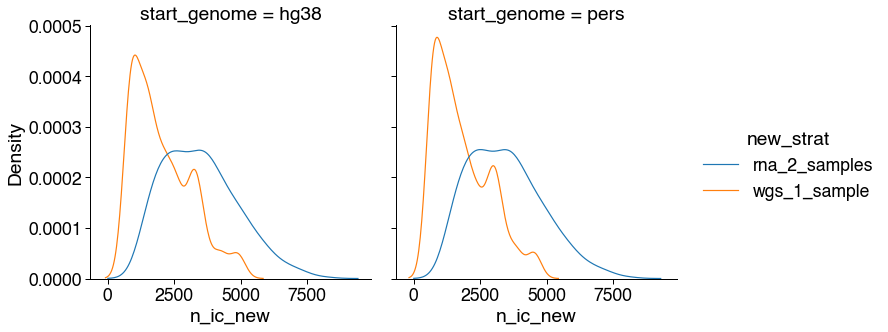

In [250]:
init_plot_settings(aspect='rectangle')
ax = sns.displot(df,
            col='start_genome',
            x='n_ic_new',
            hue='new_strat',
            kind='kde', common_norm=False)

,sample_28_index,n_ic_start,start_genome,n_ic_new,new_strat,wgs_sample_2_index
0,0,98126,hg38,1425,rna_2_samples,NaN
0,0,98126,hg38,840,wgs_1_sample,0.0
0,0,98126,hg38,899,wgs_1_sample,1.0
0,1,98285,hg38,1266,rna_2_samples,NaN
0,1,98285,hg38,766,wgs_1_sample,0.0


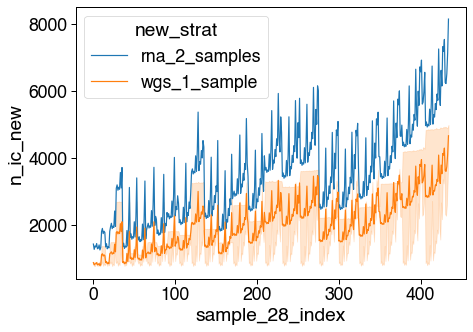

In [259]:
init_plot_settings(aspect='rectangle')
temp = df.loc[df.start_genome=='hg38']
ax = sns.lineplot(temp,
            x='sample_28_index',
            y='n_ic_new',
            hue='new_strat')
temp.head()

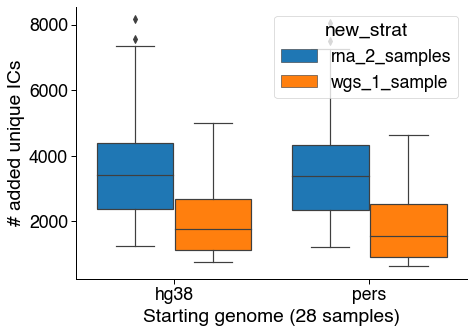

In [252]:
init_plot_settings(aspect='rectangle')
ax = sns.boxplot(df,
            x='start_genome',
            y='n_ic_new',
            hue='new_strat',
            saturation=1)
_ = ax.set(xlabel='Starting genome (28 samples)', ylabel='# added unique ICs')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

In [231]:
# df.to_csv('250307_28_sample_experiment.tsv', sep='\t')

,sample_28_index,n_ic_start,start_genome,n_ic_new,new_strat,wgs_sample_2_index
0,0,98126,hg38,1425,rna_2_samples,NaN
0,0,101900,pers,1401,rna_2_samples,NaN
0,0,98126,hg38,840,wgs_1_sample,0.0
0,0,101900,pers,701,wgs_1_sample,0.0
0,0,98126,hg38,899,wgs_1_sample,1.0


In [174]:
# df.to_csv('250306_28_sample_experiment.tsv', sep='\t')

In [232]:
# temp = pd.read_csv('250306_28_sample_experiment.tsv', sep='\t')
# temp.head()

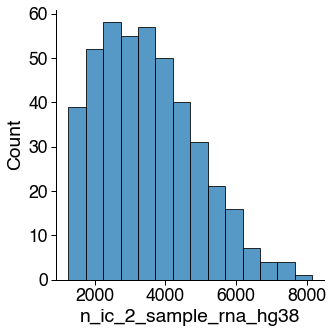

In [176]:
temp = df.drop(['sample_2_index', 'n_ic_1_sample_wgs_hg38', 'n_ic_1_sample_wgs_pers'], axis=1).drop_duplicates()
sns.displot(temp, kind='hist', x='n_ic_2_sample_rna_hg38')

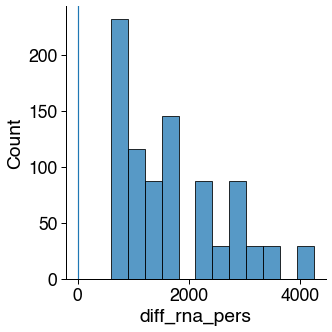

In [191]:
# plot relative gain in ICs for 1 WGS+RNA-seq vs. 2 RNA-seq
# for comparing to pers only ICs
temp = df[['sample_28_index', 'n_ic_28_pers', 'n_ic_2_sample_rna_pers', 'n_ic_1_sample_wgs_pers', 'sample_2_index']]
temp['diff_rna_pers'] = temp['n_ic_2_sample_rna_pers']-temp['n_ic_1_sample_wgs_pers']
temp.head()
ax = sns.displot(temp, x='diff_rna_pers')
plt.axvline(x=0)

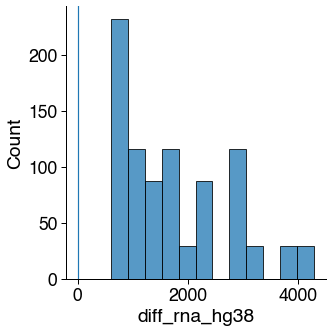

In [192]:
# plot relative gain in ICs for 1 WGS+RNA-seq vs. 2 RNA-seq
# for comparing to hg38 only ICs
temp = df[['sample_28_index', 'n_ic_28_hg38', 'n_ic_2_sample_rna_hg38', 'n_ic_1_sample_wgs_hg38', 'sample_2_index']]
temp['diff_rna_hg38'] = temp['n_ic_2_sample_rna_hg38']-temp['n_ic_1_sample_wgs_hg38']
temp.head()
ax = sns.displot(temp, x='diff_rna_hg38')
plt.axvline(x=0)

In [193]:
# plot 4 dists (rna, hg38 vs. pers) together but need to melt
df.head()

,sample_28_index,n_ic_28_hg38,n_ic_28_pers,n_ic_2_sample_rna_hg38,n_ic_2_sample_rna_pers,n_ic_1_sample_wgs_hg38,n_ic_1_sample_wgs_pers,sample_2_index
0,0,98126,101900,1425,1401,667,656,0
0,0,98126,101900,1425,1401,767,756,1
0,1,98285,102041,1266,1251,608,602,0
0,1,98285,102041,1266,1251,661,652,1
0,2,98183,101966,1368,1355,610,605,0


## ICs w/ novel splicing

In [50]:
file = proc_cfg(config['lr']['td_personal']['cerb']['ic_summary'],od)
df = pd.read_csv(file)
df.drop('Unnamed: 0', axis=1, inplace=True)
df['detected'] = True

# 1.5 only novel ics and count per cell line
print(len(df.index))
temp = df.loc[(df.structural_category!='full-splice_match')&\
              (df.structural_category!='incomplete-splice_match')]
print(len(temp.index))

# get only the detection from mapping
temp = temp[['ic_id', 'cell_line_id', 'map_genome', 'detected']]
temp = temp.drop_duplicates()
temp = temp.pivot(index=['ic_id', 'cell_line_id'], 
                columns=['map_genome'],
                values=['detected'])

# flatten
temp.columns = temp.columns.get_level_values(1)
temp.columns.name = None

# reset index to make it a flat DataFrame
temp = temp.reset_index()

# fill missing values with False
temp = temp.fillna(False)

12993951
4280955


In [51]:
cell_line_ids = temp.cell_line_id.unique().tolist()

In [52]:
len(temp.ic_id.unique())

103547

In [37]:
import itertools

big_df = pd.DataFrame()
# each group of 28
combinations = list(itertools.combinations(cell_line_ids, 28))
for i, comb in enumerate(combinations[:5]):
    
    # how many ICs do we detect w/ hg38 for these?
    ic_hg38 = temp.loc[(temp.cell_line_id.isin(comb))&\
                              (temp.hg38==True)].ic_id.unique()
    n_ic_hg38 = len(ic_hg38)
    
    # how many ICs do we detect w/ pers. haps for these?
    ic_pers = temp.loc[(temp.cell_line_id.isin(comb))&\
                          ((temp.hap1+temp.hap2)>0)].ic_id.unique()
    n_ic_pers = len(ic_pers)
    
    
    # addition of things
    missing_ids = list(set(cell_line_ids)-set(comb))    
    # how many ics would we get by adding 2 rna-seq samples 
    # (ie hg38 samples, both missing)
    ics_rna_seq = temp.loc[(temp.cell_line_id.isin(missing_ids))&\
                          (temp.hg38==True)].ic_id.unique()
    n_ics_rna_seq_hg38 = len(list(set(ics_rna_seq)-set(ic_hg38)))
    n_ics_rna_seq_pers = len(list(set(ics_rna_seq)-set(ic_pers)))
    
    # how many ics would we get by adding 1 rna-seq sample
    # w/ personalized haplotype?
    # (ie hap1/hap2 samples, 1 missing sample at a time)
    for j, missing_cell_line_id in enumerate(missing_ids):
        # how many ics would we get by adding 2 rna-seq samples 
        ics_rna_wgs_seq = temp.loc[(temp.cell_line_id==missing_cell_line_id)&\
                              (temp.hg38==True)].ic_id.unique()
        n_ics_rna_wgs_seq_hg38 = len(list(set(ics_rna_wgs_seq)-set(ic_hg38)))
        n_ics_rna_wgs_seq_pers = len(list(set(ics_rna_wgs_seq)-set(ic_pers)))
        
        
        data = [[i, j, n_ic_hg38, n_ic_pers,
                n_ics_rna_seq_hg38, n_ics_rna_seq_pers,
                n_ics_rna_wgs_seq_hg38, n_ics_rna_wgs_seq_pers]]
        cols = ['iter_28_samples', 'iter_missing_samples', 'n_ic_hg38', 'n_ic_pers',
                'n_ics_rna_seq_hg38', 'n_ics_rna_seq_pers',
                'n_ics_rna_wgs_seq_hg38', 'n_ics_rna_wgs_seq_pers']
        temp3 = pd.DataFrame(data=data, columns=cols)
        big_df = pd.concat([temp3, big_df], axis=0)

In [47]:
# big_df.to_csv('250305_28_sample_experiment.tsv', sep='\t') # this one was saved w/ all 434 combinations

In [33]:
len(temp.loc[(temp.cell_line_id.isin(comb))&\
          (temp.hg38==True)].ic_id.unique())

95997

In [41]:
temp = big_df.drop(['iter_missing_samples', 'n_ics_rna_wgs_seq_hg38', 'n_ics_rna_wgs_seq_pers'], axis=1).drop_duplicates()
sns.displot(temp, kind='hist', x='n_ics_rna_seq_hg38')

In [42]:
len(big_df.index)

870

In [43]:
len(temp.index)

435

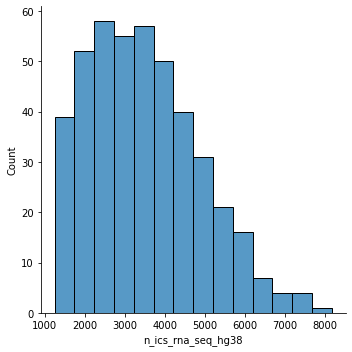

In [53]:
# debugging
import itertools

big_df = pd.DataFrame()
# each group of 28
combinations = list(itertools.combinations(cell_line_ids, 28))
for i, comb in enumerate(combinations[:5]):
    break

In [54]:
temp.head()

,ic_id,cell_line_id,hap1,hap2,hg38
0,GL000194.1_-_112791-62949,NA18561,True,True,True
1,GL000194.1_-_113533-112850-112791-62949,HG03719,True,True,True
2,GL000194.1_-_114262-112850-112791-62949,HG03729,True,True,True
3,GL000194.1_-_114778-112850-112791-62949,NA18542,True,True,True
4,GL000194.1_-_114981-112850-112791-62949,HG01975,True,True,True


In [57]:
# number / identity of the ICs discovered in this combination

# in pers. haps
temp2 = temp.loc[(temp.cell_line_id.isin(comb))&
               (temp.hap1+temp.hap2)>0]

In [58]:
len(temp.index)

486801

In [60]:
len(temp2.index)

456041

In [61]:
len(temp2.ic_id.unique())

99701